In [1]:
!pip install -r /mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/requirements.txt


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [15]:
import sys
sys.path.append('/mnt/c/Users/santhosh/Downloads/MedMamba-main')


In [ ]:
import importlib.util
import sys

module_name = 'MedMamba'
module_path = '/path/to/Medmamba.py'

spec = importlib.util.spec_from_file_location(module_name, module_path)
medmamba = importlib.util.module_from_spec(spec)
sys.modules[module_name] = medmamba
spec.loader.exec_module(medmamba)

In [2]:
import os
import sys
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from tqdm import tqdm
from MedMamba import VSSM as medmamba  # Import MedMamba model
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Learning Rate Scheduler
from torch.utils.data import random_split, DataLoader

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # Load Pretrained EfficientNetB0
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        
        # Remove the final classification layer
        self.efficient_net.classifier = nn.Identity()
        
        # Load Medmamba Model
        self.medmamba_model = medmamba(num_classes=num_classes)

        # Define a new classifier combining both models
        self.classifier = nn.Sequential(
            nn.Linear(1000 + 285, 512),  # Combining EfficientNet & Medmamba outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Final classification layer
        )

    def forward(self, x):
        eff_out = self.efficient_net(x)
        med_out = self.medmamba_model(x)
        combined_out = torch.cat((eff_out, med_out), dim=1) 

        return self.classifier(combined_out)

# Initialize the new model
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device.")

    data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training",
                                   transform=data_transform)

    # Split dataset into 80% training, 20% validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")

    batch_size = 8
    num_classes = len(dataset.classes)  # Automatically detect number of classes

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Load Model
    net = CombinedModel(num_classes=num_classes)
    net.to(device)

    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    # Learning Rate Scheduler (Reduces LR if val_accuracy plateaus)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

    # Early Stopping Parameters
    early_stop_patience = 10
    no_improvement_epochs = 0

    # Training loop
    epochs = 100
    best_acc = 0.0
    save_path = 'EfficientMedMambaNet2.pth'
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)

        for step, data in enumerate(train_bar):
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move to GPU

            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_description(f"Epoch [{epoch+1}/{epochs}] Loss: {loss:.4f}")

        # Validation
        net.eval()
        acc = 0.0
        with torch.no_grad():
            val_bar = tqdm(val_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs = net(val_images)
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels).sum().item()

        val_accurate = acc / len(val_dataset)
        print(f"[Epoch {epoch+1}] Train Loss: {running_loss / len(train_loader):.4f}  Val Accuracy: {val_accurate:.4f}")

        # Reduce LR if validation accuracy doesn't improve
        scheduler.step(val_accurate)

        # Check for Early Stopping
        if val_accurate > best_acc:
            best_acc = val_accurate
            no_improvement_epochs = 0  # Reset counter
            torch.save(net.state_dict(), save_path)
        else:
            no_improvement_epochs += 1  # Increment counter

        if no_improvement_epochs >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation accuracy.")
            break  # Stop training

    print("Finished Training")

if __name__ == '__main__':
    main()


Using cuda:0 device.
Training Samples: 2924, Validation Samples: 732
100%|██████████| 92/92 [00:06<00:00, 13.29it/s]
[Epoch 1] Train Loss: 0.7985  Val Accuracy: 0.8074
100%|██████████| 92/92 [00:06<00:00, 13.36it/s]
[Epoch 2] Train Loss: 0.5929  Val Accuracy: 0.8292
100%|██████████| 92/92 [00:06<00:00, 13.44it/s]
[Epoch 3] Train Loss: 0.4887  Val Accuracy: 0.8320
100%|██████████| 92/92 [00:06<00:00, 13.56it/s]
[Epoch 4] Train Loss: 0.4301  Val Accuracy: 0.8374
100%|██████████| 92/92 [00:06<00:00, 13.54it/s]
[Epoch 5] Train Loss: 0.3735  Val Accuracy: 0.8142
100%|██████████| 92/92 [-1:59:42<00:00, -5.06it/s]
[Epoch 6] Train Loss: 0.2935  Val Accuracy: 0.8320
100%|██████████| 92/92 [00:06<00:00, 13.30it/s]
[Epoch 7] Train Loss: 0.2551  Val Accuracy: 0.8251
100%|██████████| 92/92 [00:06<00:00, 13.24it/s]
[Epoch 8] Train Loss: 0.2215  Val Accuracy: 0.8333
100%|██████████| 92/92 [00:06<00:00, 13.58it/s]
[Epoch 9] Train Loss: 0.1878  Val Accuracy: 0.8183
100%|██████████| 92/92 [00:06<00:00, 

In [12]:
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from MedMamba import VSSM as medmamba  # Import your MedMamba model

# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load full dataset
dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training", transform=data_transform)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))   # 70% for training
val_size = int(0.15 * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get number of classes
num_classes = len(dataset.classes)
class_names = dataset.classes

# Define Combined Model
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # Load Pretrained EfficientNetB0
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        
        # Remove the final classification layer
        self.efficient_net.classifier = nn.Identity()
        
        # Load Medmamba Model
        self.medmamba_model = medmamba(num_classes=num_classes)

        # Define a new classifier combining both models
        self.classifier = nn.Sequential(
            nn.Linear(1000 + 285, 512),  # Combining EfficientNet & Medmamba outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Final classification layer
        )

    def forward(self, x):
        eff_out = self.efficient_net(x)
        med_out = self.medmamba_model(x)
        combined_out = torch.cat((eff_out, med_out), dim=1) 

        return self.classifier(combined_out)


# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the saved model
model = CombinedModel(num_classes=num_classes)  # Use correct number of classes
model.load_state_dict(torch.load("/mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/EfficientMedMambaNet2.pth"))
model.to(device)
model.eval()

# Use Test Loader for Evaluation
test_loader = test_loader  # Using test dataset instead of validation

print(f"Data split: {train_size} train, {val_size} val, {test_size} test")


Data split: 2559 train, 548 val, 549 test


In [13]:
import numpy as np

# Initialize metrics
all_labels = []
all_preds = []
total_loss = 0.0
loss_function = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Compute loss
        loss = loss_function(outputs, labels)
        total_loss += loss.item()

        # Get predictions
        preds = torch.max(outputs, dim=1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute accuracy
accuracy = np.mean(all_preds == all_labels)

# Compute precision, recall, F1-score for each class
precision = precision_score(all_labels, all_preds, average=None, labels=range(num_classes))
recall = recall_score(all_labels, all_preds, average=None, labels=range(num_classes))
f1 = f1_score(all_labels, all_preds, average=None, labels=range(num_classes))

# Compute overall metrics (macro-average)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print(f"Test Loss: {total_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"F1-score (per class): {f1}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")


Test Loss: 0.1811
Test Accuracy: 95.81%
Precision (per class): [0.94915254 0.95035461 0.99272727 0.92307692 0.77142857]
Recall (per class): [0.93333333 0.95714286 1.         0.81818182 0.84375   ]
F1-score (per class): [0.94117647 0.95373665 0.99635036 0.86746988 0.80597015]
Precision (macro): 0.9173
Recall (macro): 0.9105
F1-score (macro): 0.9129


In [14]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt  # Importing matplotlib to show the image

# Function to load and predict
def predict_image_class(image_path, model, device):
    # Load the image
    img = Image.open(image_path)
    
    # Define the same transformations as during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # Apply transformations
    image = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Ensure the model is on the same device as the input
    model.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)  # Get the predicted class
    
    # Define your class labels
    predictions = ["Mild", "Moderate", "NO_DR", "Proliferate_DR", "Severe"]
    
    # Get the predicted class
    predicted_class = predictions[pred.item()]

    # Display the image with the prediction
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.title(f"Prediction: {predicted_class}")
    plt.show()

    # Print the predicted class
    print(f"Predicted class: {predicted_class}")

# Get the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

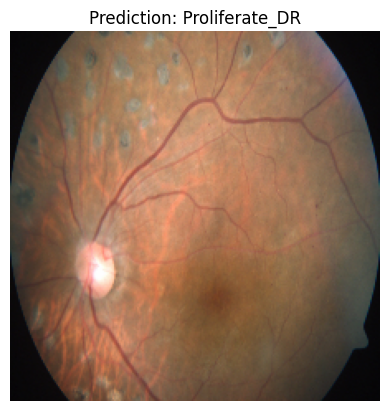

Predicted class: Proliferate_DR


In [20]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/2fe06bedb2c4.png' # Replace with your image path
predict_image_class(image_path, model, device)

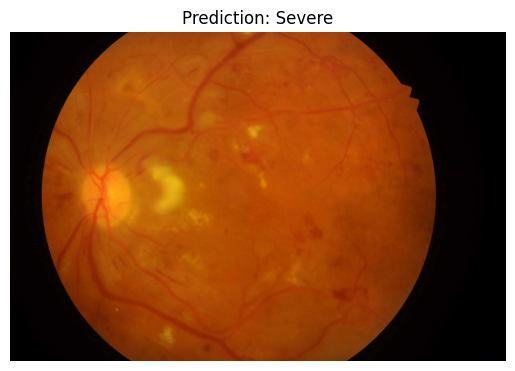

Predicted class: Severe


In [16]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/image (1).jpg' # Replace with your image path
predict_image_class(image_path, model, device)

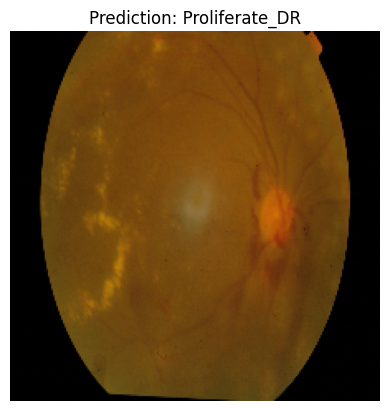

Predicted class: Proliferate_DR


In [17]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/1b32e1d775ea.png' # Replace with your image path
predict_image_class(image_path, model, device)

In [8]:
!pip install lime

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4d39b19a8f6af4c0c75dff91beda9a4d66befb1dd0802334602681e751924c33
  Stored in directory: /home/santhosh/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [36]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from efficientnet_pytorch import EfficientNet  # Ensure you have EfficientNet installed

# Define class labels
class_labels = ["Mild", "Moderate", "NO_DR", "Proliferate_DR", "Severe"]

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalization
])


# Preprocess image for LIME
def preprocess_image(image):
    image = transform(Image.fromarray(image))
    return image

# LIME's prediction function
def predict_function(images):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = torch.stack([preprocess_image(img) for img in images]).to(device)

    with torch.no_grad():
        output = model(batch)
        probabilities = F.softmax(output, dim=1)

    return probabilities.cpu().numpy()

# LIME Explanation Function
def explain_lime(image_path, model, device):
    img = Image.open(image_path)
    img_np = np.array(img)


    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np, predict_function, top_labels=5, hide_color=0, num_samples=1000
    )

    top_class = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation for Predicted Class: {class_labels[top_class]}")
    plt.axis("off")
    plt.show()


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import shap
from torchvision import transforms
from PIL import Image
from torch import nn
import cv2

# Define class labels
class_labels = ["Mild", "Moderate", "NO_DR", "Proliferate_DR", "Severe"]

# Image transformation for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for pre-trained models
])

# Prediction function
def predict_new(path, model):
    img = Image.open(path).convert('RGB')
    image = transform(img).unsqueeze(0)  # Add batch dimension
    
    # Move image to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    model.to(device)
    
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
    
    pred = torch.argmax(probabilities, dim=1).item()
    print(f"Predicted: {class_labels[pred]}")
    return image, pred, class_labels[pred]

# SHAP explanation function
def explain_with_shap(image_tensor, model):
    # Create a background dataset using random images or samples from training data
    background = np.random.rand(50, 224, 224, 3).astype(np.float32)  # Random normalized images
    
    # Define the masker for SHAP
    masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))
    
    # Create SHAP explainer with the model and masker
    explainer = shap.Explainer(model, masker)
    
    # Compute SHAP values
    shap_values = explainer(image_tensor)
    
    # Plot the SHAP values
    shap.image_plot(shap_values, image_tensor)

# Main execution
if __name__ == "__main__":
   
    model.eval()
    
    image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Mild/0ad7f631dedb.png"  # Replace with the path to your image
    
    # Predict the class of the image
    processed_image, pred_index, pred_label = predict_new(image_path, model)
    
    print(f"The model predicted the image as: {pred_label}")
    
    # Preprocess the image for SHAP (it should already be in the right format)
    shap_image_tensor = processed_image.unsqueeze(0)  # Add batch dimension
    
    # Generate SHAP explanation
    explain_with_shap(shap_image_tensor, model)

Predicted: NO_DR
The model predicted the image as: NO_DR


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)


100%|██████████| 1000/1000 [00:17<00:00, 57.67it/s]


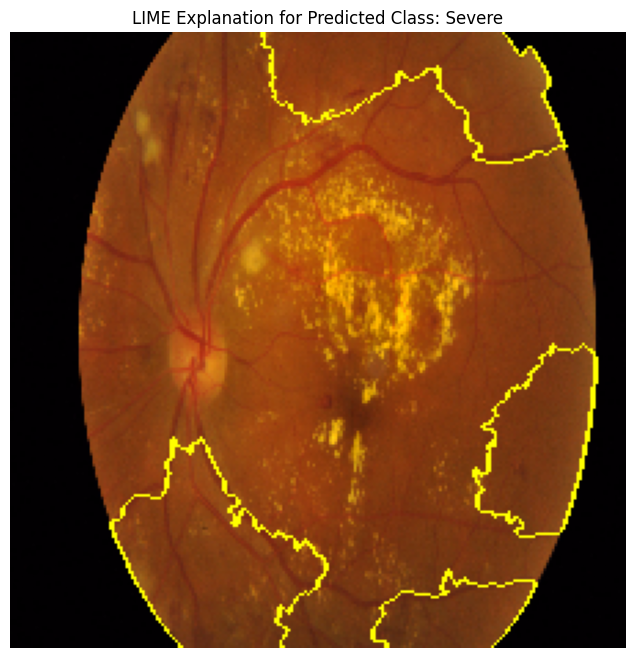

In [37]:

image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Severe/7e160c8b611e.png"
explain_lime(image_path, model, device)

In [15]:
train_dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training", transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)


In [16]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate Training Accuracy
train_accuracy = evaluate_model(model, train_loader, device)
print(f"Training Accuracy: {train_accuracy:.2f}%")


Training Accuracy: 98.66%


In [17]:
criterion = nn.CrossEntropyLoss() 
def compute_loss(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # No need for gradient calculation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute batch loss
            total_loss += loss.item() * labels.size(0)  # Multiply by batch size
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples  # Compute average loss
    return avg_loss

# Compute Training Loss
train_loss = compute_loss(model, train_loader, criterion, device)
print(f"Training Loss: {train_loss:.4f}")


Training Loss: 0.0317


In [ ]:
val_dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/validation", transform=data_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
